# Combined/Final Gibbs W-diag

In [1]:
#Load necessary packages
# %pylab notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pylab as pl
import scipy as sp
from scipy.sparse import linalg as ln
from IPython.display import HTML
from random import choices

# try:
#     plt.style.use('classic')
# except:
#     pass


In [2]:
#Define parameters, potential and vector potential
m, omega , sigma, delta, Phi =  1., 1., 1., .2, 0.
eps = 0.5
levelSpace = 0.46638204451990617 # eps = 0.5
beta = 0.1/ (levelSpace)

Ed = 0.01
omegaD = Ed / eps

#Define range of x
x_max = np.pi
x_min = -1*np.pi
dx = 0.01
x_range = np.append(np.flip(-1*np.arange(0+dx,x_max,dx)), np.arange(0,x_max,dx))
n_xq = len(x_range); 
print("n_xq=",n_xq )

#Define range of p
p_max = 15
p_min = -15
dp = 0.01
p_range_q = np.arange(p_min,p_max+dp,dp)
n_pq = len(p_range_q); 
print("n_pq=",n_pq )

n_xq= 629
n_pq= 3001


## Selecting which data to use below

In [17]:
## Quartic Potential (w/ asymmetry) 
def V(x):
    return omega/4 * (x**4 - a*x)

choices = ["all_a", "a=1", "a=0", "a=0; eps=0.3"]
choice = 3

if choice==0: 
    a_Range = ["0", "1e-2", "5e-2", "1e-1", "2e-1", "3e-1", "4e-1", "5e-1", "6e-1", "7e-1", "8e-1", "9e-1","1e0", "2", "5"]
    a_q = a_Range[0]
    eps = 0.5
    filename_base = "SingleT_asym_"+ a_q +"/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_asym_"+ a_q +"/JJ_CM_states_nearMore"
    file_save_base = "asym_"+a_q
    beta_Range = np.linspace(1.0, 2.5, 100) / levelSpace
elif choice==1: 
    a=1; eps = 0.5
    filename_base = "SingleT_asym/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_asym/JJ_CM_states_nearMore"
    file_save_base = "quartAsym"
    beta_Range = np.linspace(0.1, 4.0, 200) / levelSpace
elif choice==2: 
    a=0; eps = 0.5
    filename_base = "SingleT_quartic/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_quartic/JJ_CM_states_nearMore"
    file_save_base = "quart"
    beta_Range = np.linspace(0.1, 4.0, 200) / levelSpace
elif choice==3: 
    a = 0; eps = 0.3
    filename_base = "SingleT_quart_3eps/JJ_CM_weights_nearMore"
    filename_base_s = "SingleT_quart_3eps/JJ_CM_states_nearMore"
    file_save_base = "quart"
    beta_Range_OG = np.linspace(0.1, 4.0, 200)
    step = beta_Range_OG[2] - beta_Range_OG[1]
    beta_Range = np.arange(0.1, 8.0+step, step)/ levelSpace

In [65]:
## Cosine (JJ) potential w/ confining Potential 
def V(x):
    return omega*(1-np.cos(x)) + confin(x)

def confin(x): 
    left = 20*(1+np.tanh(20*(x-np.pi)))
    right = 20*(1-np.tanh(20*(x+np.pi)))
    return left + right

filename_base = "SingleT_mid/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_mid/JJ_CM_states_nearMore"
file_save_base = "JJ"
beta_Range = np.linspace(1.5, 2.5, 100) / levelSpace
print(beta_Range[0], beta_Range[-1])

3.2162473183205424 5.360412197200904


In [29]:
## Cosine (JJ) potential for 3 periods w/ confining Potential 
def V(x):
    return omega*(1-np.cos(x)) + confin(x)

def confin(x): 
    left = 20*(1+np.tanh(20*(x-3*np.pi)))
    right = 20*(1-np.tanh(20*(x+3*np.pi)))
    return left + right

filename_base = "SingleT_JJ_3T/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_JJ_3T/JJ_CM_states_nearMore"
file_save_base = "JJ3T"
beta_Range = np.linspace(0.1, 4.0, 200) / levelSpace


In [60]:
## Quadratic potential (apparently?)
def V(x): 
    return omega/2 * x**2

filename_base = "SingleT_quad/JJ_CM_weights_nearMore"
filename_base_s = "SingleT_quad/JJ_CM_states_nearMore"
file_save_base = "quad"
beta_Range = np.linspace(0.1, 4.0, 100) / levelSpace


## Read in weights/states

In [18]:
def readInWF(filename_base, filename_base_s, beta):     
    filename_weights = filename_base + str(round(beta,6)) + ".txt"
    filename_states = filename_base_s + str(round(beta,6)) + ".txt"
    
    ## Read the weights and states from text files
    w_alph = np.loadtxt("diagW/"+filename_weights, dtype = "complex", delimiter=',', comments='#')
    psi_alph = np.loadtxt("diagW/"+filename_states, dtype = "complex", delimiter=',', comments='#')
    
    sigma_x = np.sqrt(beta*eps**2 / m)
    dx = 0.01
    x1_max = np.pi
    x1_min = -np.pi
    x1_range_q = np.round(np.append(np.flip(-1*np.arange(dx,x1_max+dx+5*sigma_x,dx)), np.arange(0,x1_max+dx+5*sigma_x,dx)), 3)
    n_x1q = len(x1_range_q); 
    
    ## Sort based on energy values
    if len(w_alph)==len(psi_alph[0,:]): 
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        sorted_psi_alph = np.zeros_like(psi_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]
            sorted_psi_alph[:, n_j] = psi_alph[:, n]
        return x1_range_q, sorted_w_alph/np.sum(sorted_w_alph), sorted_psi_alph
    else: 
        return x1_range_q, w_alph/np.sum(w_alph), psi_alph

## Read from file
def readInNew(filename_base, beta_list): 
    weights_list = []
    for beta_i, beta in enumerate(beta_list): 
        filename = filename_base + str(round(beta_list[beta_i],6)) + ".txt"
        w_alph = np.loadtxt("diagW/"+filename,dtype = "complex", delimiter=',', comments='#')
        
        sorted_arg = np.argsort(-np.abs(w_alph))
        sorted_w_alph = np.zeros_like(w_alph)
        for n_j, n in enumerate(sorted_arg): 
            sorted_w_alph[n_j] = w_alph[n]

        weights_list += [sorted_w_alph[:600]/np.sum(sorted_w_alph[:600])]
    return weights_list

w_alph_list = readInNew(filename_base, beta_Range)
print("Found this many weights:", np.shape(w_alph_list))

i=70
beta = beta_Range[i]
print(filename_base, beta)
x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
print(len(psi_alph), len(x_range_q))

Found this many weights: (405, 600)
SingleT_quart_3eps/JJ_CM_weights_nearMore 3.155909010171146
1163 1163


## Plotting some states

(0.0, 3.0)

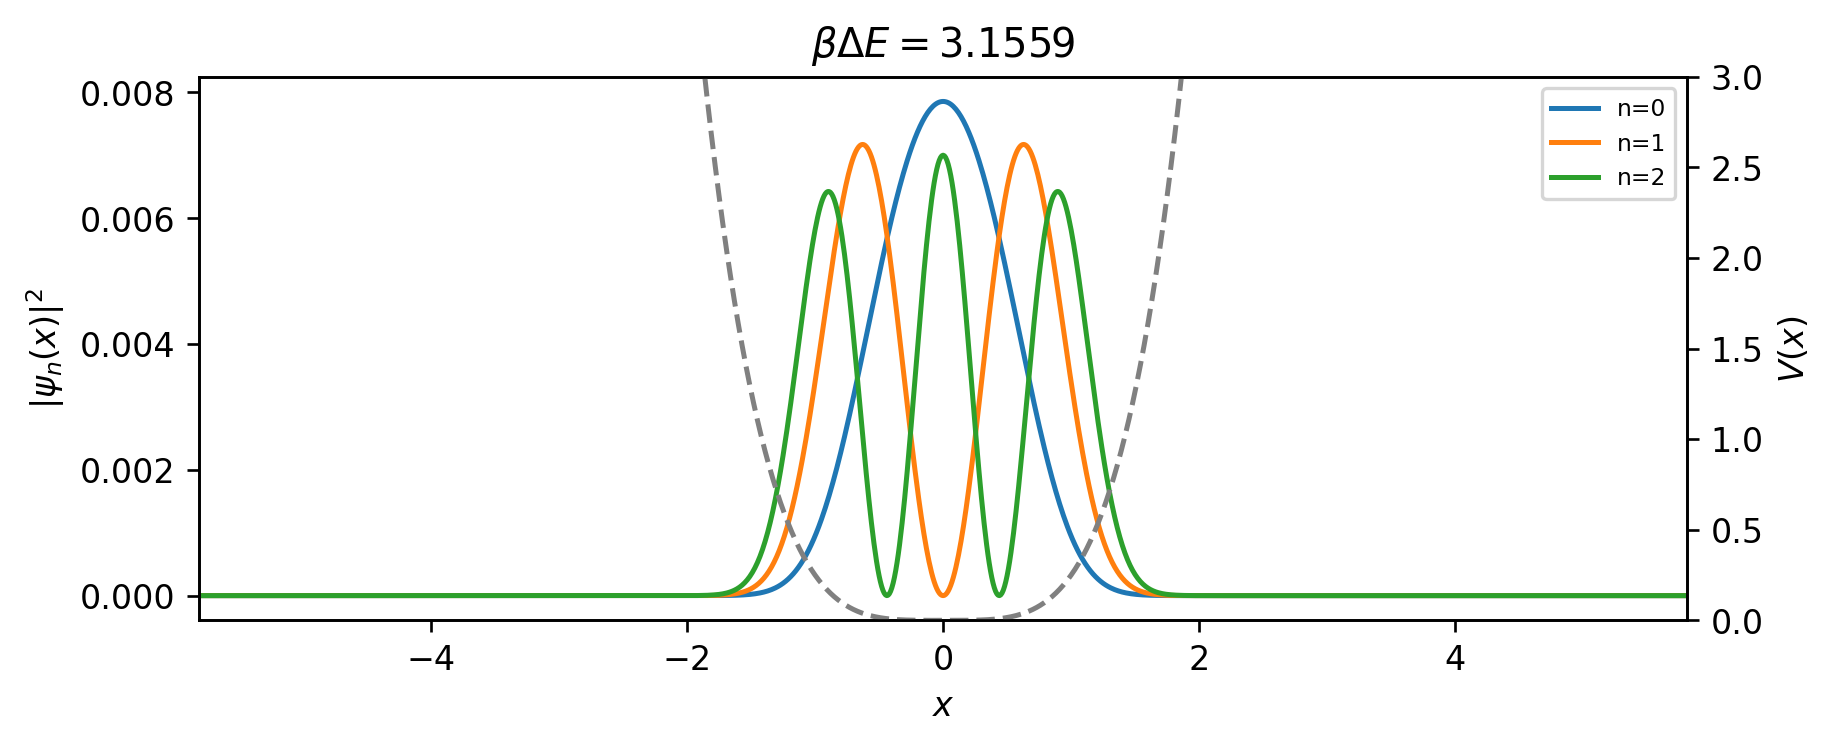

In [19]:
##Plot eigenstates
f, ax1 = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)
ax1.plot(x_range_q, np.abs(psi_alph[:,0])**2, label="n=0")
ax1.plot(x_range_q, np.abs(psi_alph[:,1])**2, label="n=1")
ax1.plot(x_range_q, np.abs(psi_alph[:,2])**2, label="n=2")
# ax1.plot(x_range_q, np.abs(psi_alph[:,3])**2, label="n=3")
# ax1.plot(x_range_q, np.abs(psi_alph[:,4])**2, label="n=4")
ax1.legend(fontsize=7)

ax1.set_ylabel(r"$|\psi_n(x)|^2$")
ax1.set_xlabel(r"$x$")
ax1.set_xlim([x_range_q[0], x_range_q[-1]])
ax1.set_title(r"$\beta \Delta E = "+str(round(beta_Range[i], 4))+"$")

ax2 = ax1.twinx()
ax2.plot(x_range_q,V(x_range_q), '--',color='grey')
ax2.set_ylabel(r"$V(x)$")
ax2.set_ylim([0,3])

## Plotting Energy spectrum and weights spectrum

Plots_W/CM_eps0.3_quart_Ebeta.png


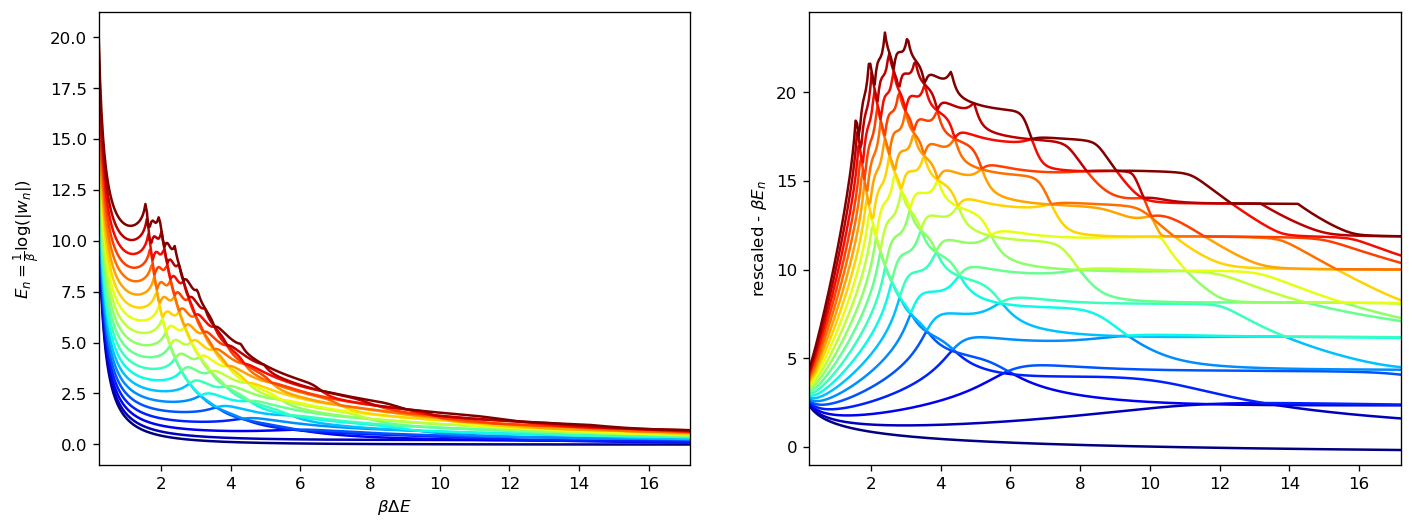

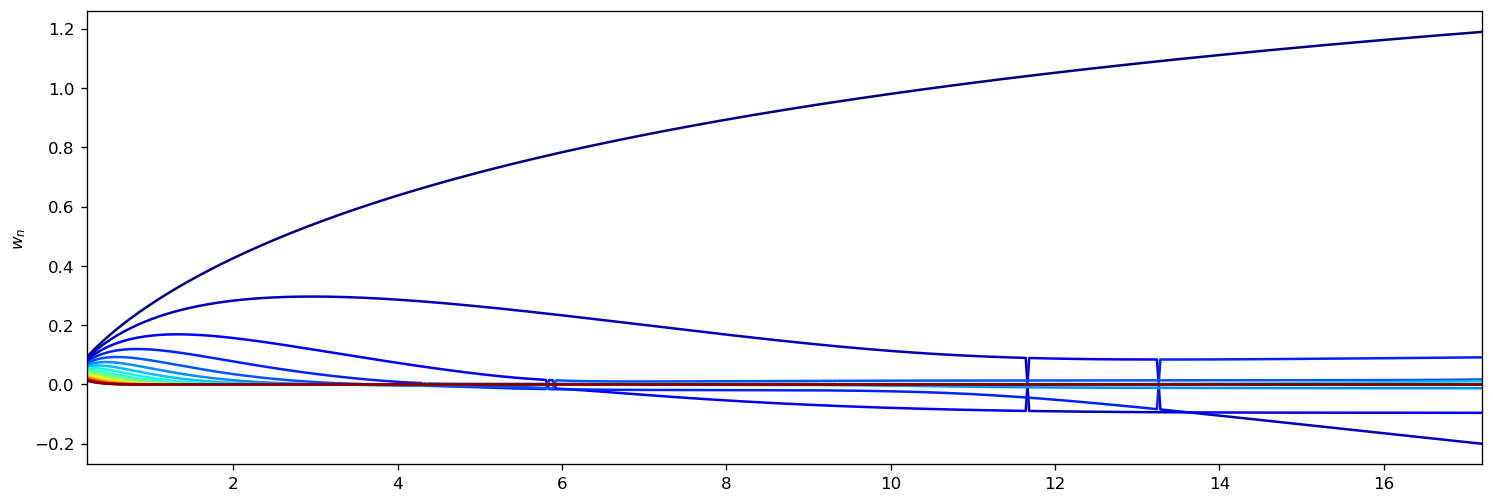

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), dpi=120, frameon=True)
f3, ax3 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

states_n = 20

colors = pl.cm.jet(np.linspace(0,1,states_n))

EigEnergies = np.zeros((len(beta_Range), states_n))
EigEnergies_re = np.zeros((len(beta_Range), states_n))
weights_toPlot = np.zeros((len(beta_Range), states_n))

for j_i, j in enumerate(beta_Range): 
    for k in range(0,states_n): 
        EigEnergies[j_i, k] = -np.log(np.abs(w_alph_list[j_i][k]))/beta_Range[j_i]
        EigEnergies_re[j_i, k] = -np.log(np.abs(w_alph_list[j_i][k]))
        weights_toPlot[j_i, k] = np.real(w_alph_list[j_i][k])
        
for k in range(0, states_n):
    ax1.plot(beta_Range, EigEnergies[:,k], '-', color=colors[k], label="n="+str(k))
    ax2.plot(beta_Range, EigEnergies_re[:,k], '-', color=colors[k], label="n="+str(k))
    ax3.plot(beta_Range, weights_toPlot[:,k], '-', color=colors[k], label="n="+str(k))

ax1.set_ylabel(r"$E_n = \frac{1}{\beta}\log(|w_n|)$")
ax1.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"rescaled - $\beta E_n$")
ax3.set_ylabel(r"$w_n$")
# ax1.legend(loc='center left', fontsize=7, bbox_to_anchor=(1, 0.5))
ax1.set_xlim(left=beta_Range[0], right=beta_Range[-1])
ax2.set_xlim(left=beta_Range[0], right=beta_Range[-1])
ax3.set_xlim(left=beta_Range[0], right=beta_Range[-1])
ax1.set_ylim(bottom=-1)
ax2.set_ylim(bottom=-1)

filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_Ebeta.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

### Weights at given T

Plots_W/CM_eps0.3_quart_weights.png


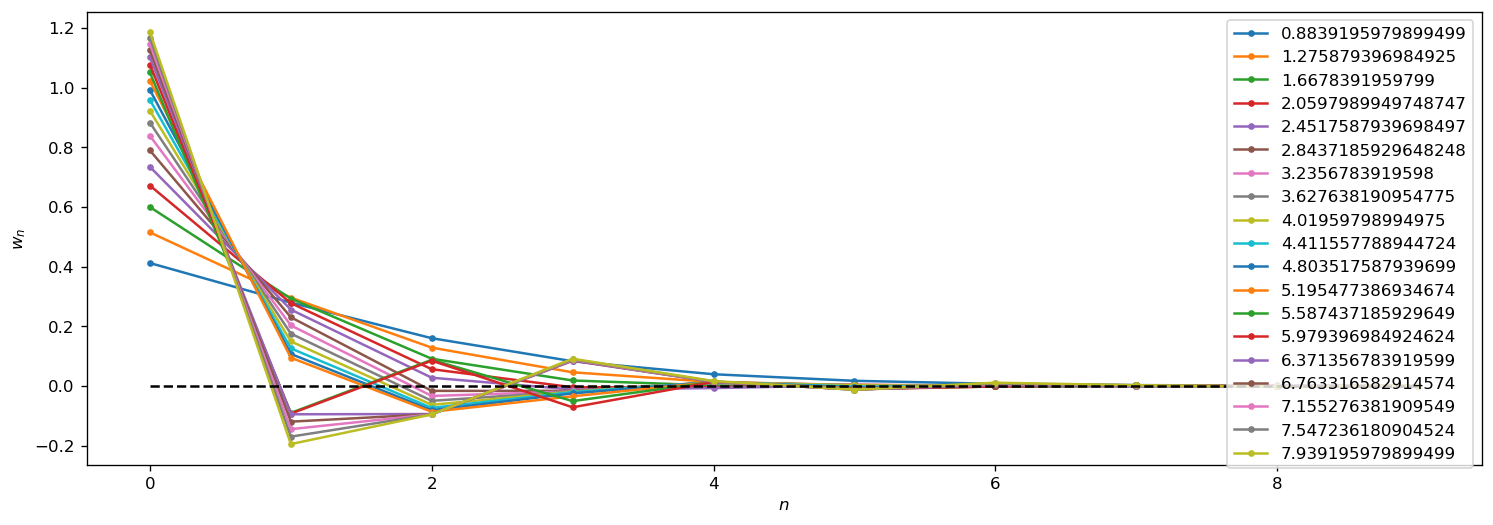

In [26]:
f, ax1 = plt.subplots(1, 1, figsize = (15,5), dpi=120, frameon=True)

for beta_i, beta in enumerate(beta_Range):
    if 20 < beta_i < len(beta_Range) and beta_i%20==0:
        ax1.plot(weights_toPlot[beta_i, :10], '.-', label=str(beta*levelSpace))
ax1.plot(np.arange(0,10), 0*np.arange(0,10), 'k--')
ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$w_n$")
ax1.legend(fontsize=10)
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_weights.png"
print(filename)
# f.savefig(filename, dpi=200, bbox_inches='tight') 

## Energies with sign of weights marked

Plots_W/CM_eps0.3_quart_Ebeta_labelled.png
pos - blue
neg - red


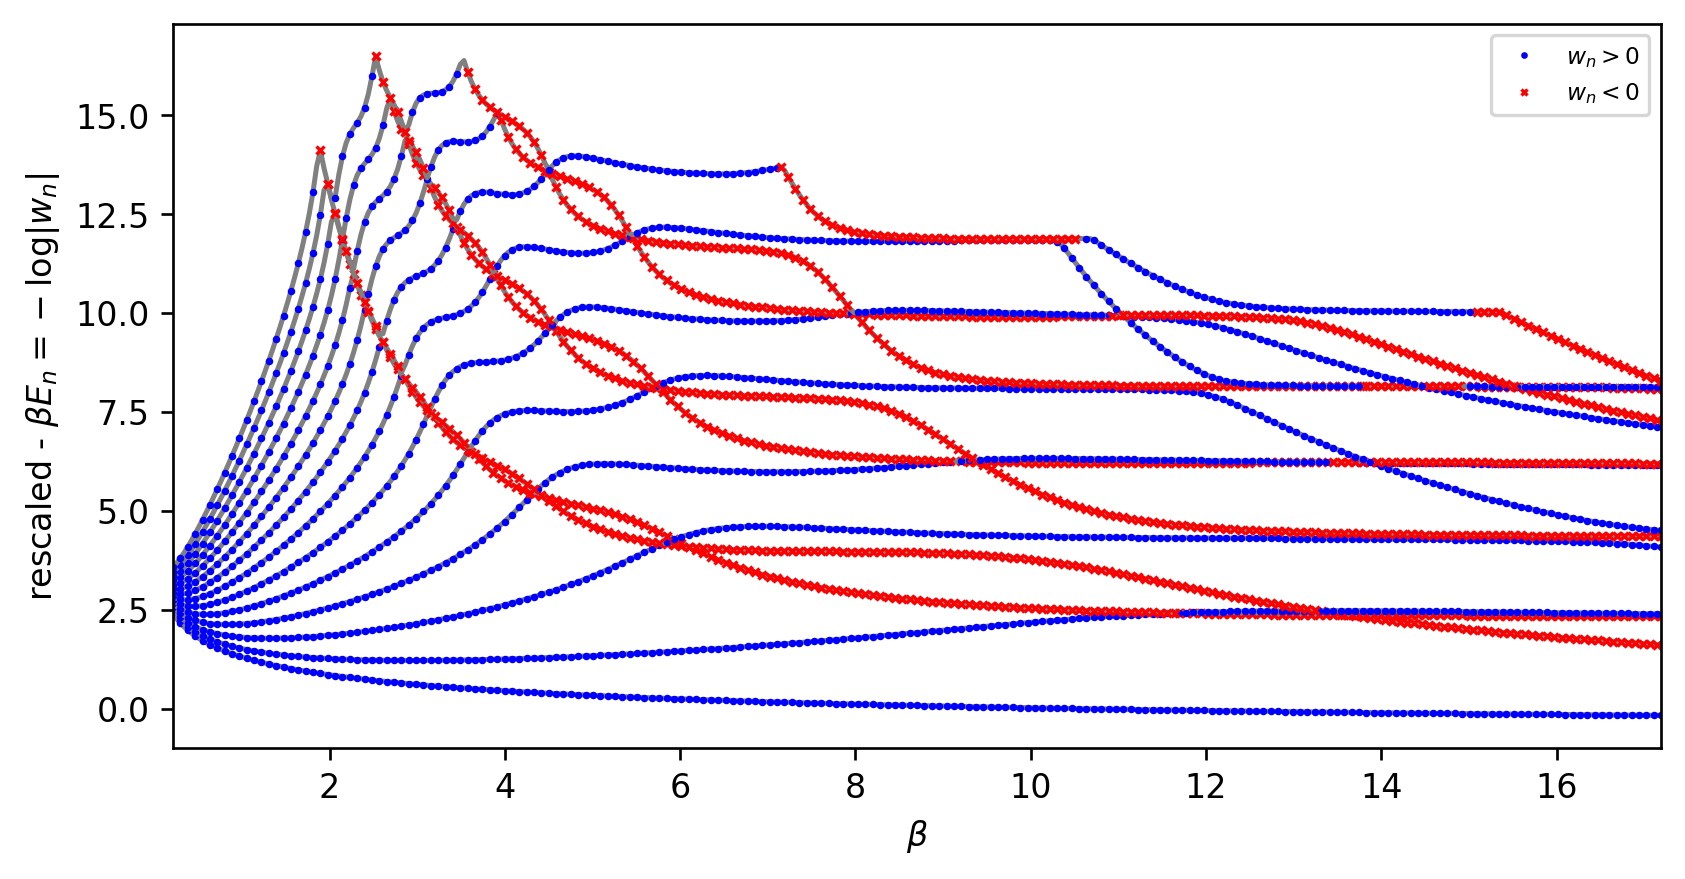

In [33]:
f, (ax2) = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
states_n = 14

colors = pl.cm.jet(np.linspace(0,1,states_n))

for k in range(0, states_n):

    EigEnergies_pos = np.array([])
    beta_list_pos = np.array([])
    EigEnergies_neg = np.array([])
    beta_list_neg = np.array([])
    EigEnergies_re = np.zeros((len(beta_Range)))

    for j_i, j in enumerate(beta_Range): 
        EigEnergies_re[j_i] = -np.log(np.abs(w_alph_list[j_i][k]))

        if w_alph_list[j_i][k] >= 0: 
            EigEnergies_pos = np.append(EigEnergies_pos, EigEnergies_re[j_i])
            beta_list_pos = np.append(beta_list_pos, beta_Range[j_i])
        else: 
            EigEnergies_neg = np.append(EigEnergies_neg, EigEnergies_re[j_i])
            beta_list_neg = np.append(beta_list_neg, beta_Range[j_i])

    ax2.plot(beta_Range, EigEnergies_re, '-', color="grey")
    ax2.plot(beta_list_pos[::2], EigEnergies_pos[::2], ".", markersize=2.5, linewidth=0,color="b")
    ax2.plot(beta_list_neg[::2], EigEnergies_neg[::2], "x", markersize=2.5, linewidth=0,color="r")

ax2.plot(0, 0, ".", markersize=2, linewidth=0,color="b", label=r"$w_n > 0$")
ax2.plot(0, 0, "x", markersize=2, linewidth=0,color="r", label=r"$w_n < 0$")

ax2.set_xlabel(r"$\beta$")
ax2.set_ylabel(r"rescaled - $\beta E_n = -\log|w_n|$")
ax2.set_xlim([beta_Range[0], beta_Range[-1]])
ax2.legend(fontsize=7)
# ax2.set_title("pos=Blue; neg=Red;", fontsize=10)
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_Ebeta_labelled.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)

print("pos - blue")
print("neg - red")

## Entropies 

Plots_W/CM_eps0.3_quart_entropy.png
minimums: [239 245 245 245 245] [4 4 4 4 4]
vN: 205 10.089427098409903
10.509640315878919


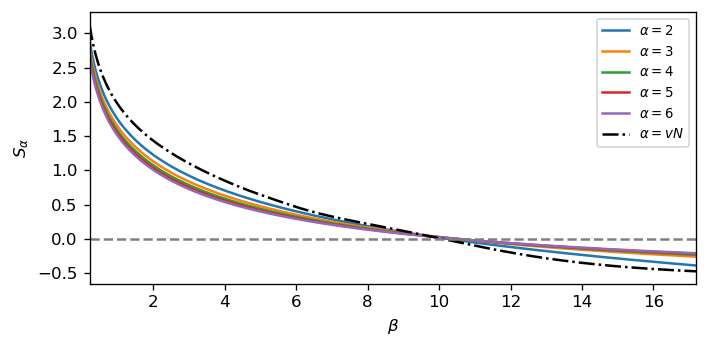

In [42]:
f, ax1 = plt.subplots(1, 1, figsize = (6,3), dpi=120, frameon=True)

powerRange = np.arange(2, 7, 1)
# powerRange = np.append((1 + np.logspace(-3, 0, 10)), [3])
# powerRange = 1 + np.logspace(-4, 0, 10)

minS_point = np.zeros_like(powerRange)
minS_beta = np.zeros_like(powerRange)

colors = pl.cm.jet(np.linspace(0,1,len(powerRange)))

for power_i, power in enumerate(powerRange):
    entropy2 = np.zeros_like(beta_Range, complex)
    for i in range(len(entropy2)): 
        entropy2[i] += 1/(1-power)*np.log(np.abs(np.sum( np.power(w_alph_list[i], power) )))
    ax1.plot(beta_Range, np.real(entropy2), '-', label=r"$\alpha=$"+str(round(power, 6)))
    
    minS_point[power_i] = np.argmin(np.abs(entropy2))
    minS_beta[power_i] = beta_Range[int(minS_point[power_i])]*levelSpace

entropyV = np.zeros_like(beta_Range, complex)
for i in range(len(entropy2)): 
    entropyV[i] += -1*(np.sum(w_alph_list[i]*np.log(w_alph_list[i])))
ax1.plot(beta_Range, np.real(entropyV), '-.', color='black', label=r"$\alpha=vN$")

ax1.plot(beta_Range, beta_Range*0, '--', color='gray')

ax1.set_ylabel(r"$S_\alpha$")
ax1.set_xlabel(r"$\beta$")
ax1.set_xlim([beta_Range[0], beta_Range[-1]])
ax1.legend(fontsize=8, loc=1)
f.tight_layout()

filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_entropy.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)
print("minimums:", minS_point, minS_beta)
print("vN:", np.argmin(np.abs(entropyV)), beta_Range[np.argmin(np.abs(np.real(entropyV)))])

print(beta_Range[minS_point[-1]])

## Compute coupling matrix

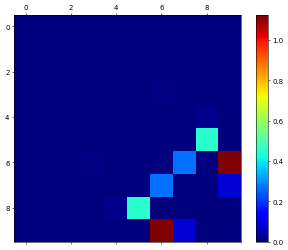

In [34]:
## Compute matrix components 
def A_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta): 
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    W1_psi = np.dot(d_beta_W, psi_alph[:,k])
    A_n = np.vdot(W1_psi, psi_alph[:,j]) / Zx
    
    return np.abs(A_n)**2 / (np.real(w_alph[j] - w_alph[k])**2)

n_Max = 10
Coupling_M = np.zeros((n_Max, n_Max))

d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
for x1_i, x1 in enumerate(x_range_q): 
    xi = x1 - x_range_q
    x_x = (x1 + x_range_q) / 2
    d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                        * np.exp((-m*xi**2)/(2.*beta*eps**2)-beta*V(x_x))
    
for j in range(2,n_Max): 
    for k in range(n_Max): 
        if j!=k: 
            Coupling_M[j,k] = A_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = A_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)

fig, ax1 = plt.subplots(1, 1, figsize = (8,6), dpi=50, frameon=False)
im = ax1.matshow(Coupling_M, cmap=plt.cm.jet)
fig.colorbar(im, ax=ax1)


### Coupling vs. $\beta$

In [22]:
## Computing coupling vs. beta
n_Max = 100
Coup_M_beta = np.zeros((n_Max, n_Max,len(beta_Range)))

for beta_i, beta in enumerate(beta_Range): 
    print(beta_i, end=" ")    
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    Coupling_M = np.zeros((n_Max, n_Max))

    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                             * np.exp((-m*xi**2)/(2.*beta*eps**2)) * np.exp(-beta*V(x_x)) / Zx

    for j in range(n_Max): 
        for k in range(j+1,n_Max): 
            Coupling_M[j,k] = A_nm(j,k, d_beta_W, x_range_q, w_alph, psi_alph, beta)
            Coupling_M[k,j] = A_nm(k,j, d_beta_W, x_range_q, w_alph, psi_alph, beta)

    Coup_M_beta[:,:, beta_i] = Coupling_M[:,:]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 

KeyboardInterrupt: 

In [ ]:
f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

for j in range(3,n_Max-3): 
    for k in range(j+1,n_Max-3): 
        ax2.plot(beta_Range*levelSpace, Coup_M_beta[j-1,k-1,:], ".-", label=r"$A_{"+str(j)+str(k)+"}$")
    
ax2.set_xlabel(r"$\beta \Delta E$")
ax2.set_ylabel(r"Coupling matrix - $M_{jk}$")
ax2.set_xlim([1, 2.5])
ax2.legend()
filename = "Plots_W/JJ_CM_eps"+str(eps)+"_"+file_save_base+"_AGP.png"
print(filename)

### Norm of AGP

$$ \text{Norm}[n] = \sum_j \frac{ |\langle j| \partial_\beta W | n\rangle|^2 }{ (w_j - w_n)^2 }$$ 

In [36]:
## Computing coupling vs. beta

n_Max = 100

A_n = np.zeros((n_Max, len(beta_Range))); A_n_weight = np.zeros((len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)
norm_2 = np.zeros(len(beta_Range))

for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /=np.sum(w_alph)
    norm_2[beta_i] = np.abs(np.sum( np.power(w_alph, 2) ))
    
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                             * np.exp((-m*xi**2)/(2.*beta*eps**2)) * np.exp(-beta*V(x_x))# / Zx
    for j in range(n_Max): 
        dbW_psi = np.dot(d_beta_W,psi_alph[:,j])
        for k in range(n_Max): 
            if j!=k: 
                A_n[j,beta_i]+= np.real(w_alph[j]**2 * np.vdot(psi_alph[:,k],dbW_psi)**2 /np.real(w_alph[j] - w_alph[k])**2)

    A_n_weight[beta_i] += np.sum( beta**2 * np.real(w_alph[:n_Max]) * np.abs(A_n[:,beta_i]) )
    A_n_weight[beta_i] /= np.sum(w_alph)
    
    ## And also compute the entropy, for comparing to normAGP
    entropy[beta_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))

0 

<ipython-input-36-5e9dc6670708>:29: ComplexWarning: Casting complex values to real discards the imaginary part
  A_n_weight[beta_i] /= np.sum(w_alph)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

Plots_W/CM_eps0.3_quartAGPnorm.png


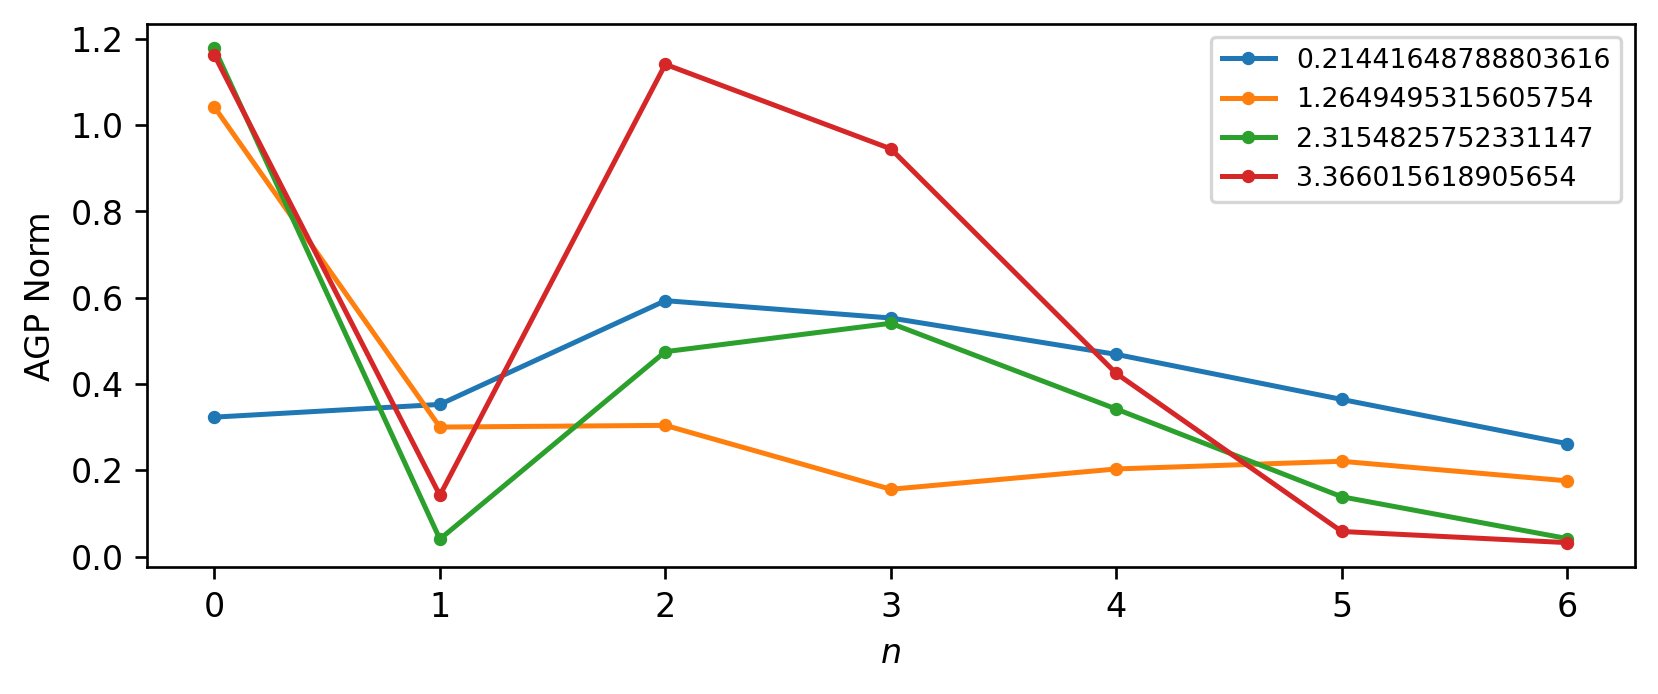

In [37]:
f, (ax2) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

ax2.plot(A_n[:7,0], '.-', label=beta_Range[0])
ax2.plot(A_n[:7,25], '.-', label=beta_Range[25])
ax2.plot(A_n[:7,50], '.-', label=beta_Range[50])
ax2.plot(A_n[:7,75], '.-', label=beta_Range[75])
# ax2.plot(A_n[:7,105], '.-', label=beta_Range[105])
# ax2.plot(A_n[:7,122], '.-', label=beta_Range[122])
ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"AGP Norm")
ax2.legend(fontsize=8)
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"AGPnorm.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


Plots_W/CM_eps0.3_quart_AGPnorm_weighted.png


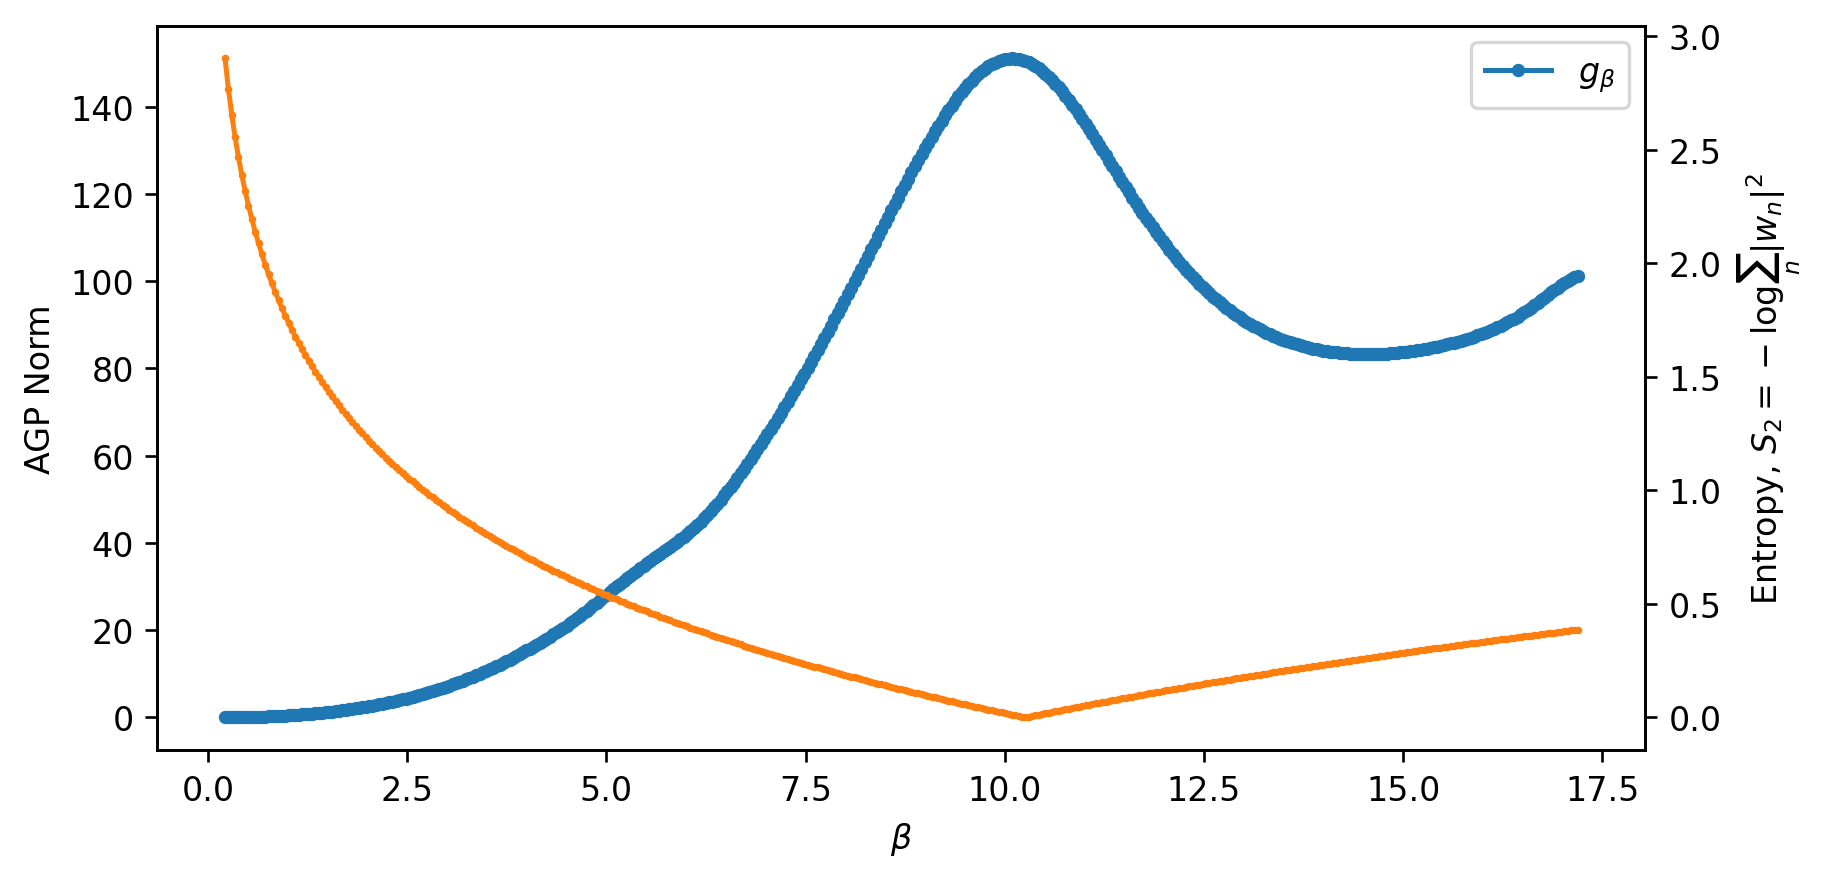

In [38]:
f, (ax) = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)

# ax.plot(beta_Range*levelSpace, A_n_weight, '-', label="unnorm")  
ax.plot(beta_Range, A_n_weight, '.-', label=r"$g_\beta$") 
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"AGP Norm")
ax.legend()
# ax.set_title(r"$a="+str(float(a_q))+"$")
# ax.set_ylim(0,10)

ax2 = ax.twinx()
ax2.plot(beta_Range, np.abs(entropy), '.-', color="C1", markersize=2.5)
# ax2.plot(beta_Range, entropy, 'r.-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_AGPnorm_weighted.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


In [183]:
print(np.abs(np.vdot(psi_alph[:,k-3],dbW_psi))**2)
print(np.real(w_alph[:n_Max]))
print(Zx)

print(np.abs(np.vdot(psi_alph[:,k-3],dbW_psi))**2 / np.real(w_alph[j] - w_alph[k-3])**2 / Zx**2)

8.95316704337497e-38
[ 1.30413556e+00 -4.38085177e-01  2.09564296e-01 -1.06667142e-01
  4.84377026e-02 -2.77183900e-02  1.49170362e-02 -7.33226693e-03
  4.42929939e-03 -2.54086627e-03  1.31235023e-03 -7.69671574e-04
  4.91833155e-04 -2.62012208e-04  1.46445015e-04 -9.66503112e-05
  5.83131623e-05 -3.14403810e-05  1.89849792e-05 -1.31880998e-05
  7.55733932e-06 -4.14966049e-06  2.72516996e-06 -1.88080958e-06
  1.09224115e-06 -5.90082783e-07  4.11731360e-07 -2.88262245e-07
  1.64214715e-07 -9.21973650e-08  6.35274737e-08 -4.72006543e-08
  2.68189438e-08 -1.46239455e-08  1.03304776e-08 -7.73867803e-09
  4.82409631e-09 -2.49842010e-09  1.66850358e-09 -1.34851270e-09
  8.49993343e-10 -4.69791925e-10  2.79465764e-10 -2.26335838e-10
  1.70157832e-10 -8.77917208e-11  4.96172661e-11 -3.80762018e-11
  3.11939523e-11 -1.97634791e-11  9.59181839e-12 -6.31335605e-12
  5.61872680e-12 -3.90170257e-12  2.22693395e-12 -1.17111723e-12
  9.24533155e-13 -8.46144746e-13  4.68662849e-13 -2.49484778e-13
  1.

## *New* Metric (Norm of AGP)

$$ g_\beta = \sum_n \beta^2 w_n^3 \frac{| \langle n | \partial_\beta W |m \rangle |^2}{(w_n - w_m)^2} = \sum_n \beta^2 w_n \frac{| \langle n | \partial_\beta W |m \rangle |^2}{(1 - w_m/w_n)^2} $$

and in our calculations below, we define: `A_n` as:

$$ A_n = \frac{| \langle n | \partial_\beta W |m \rangle |^2}{(1 - w_m/w_n)^2} $$

In [21]:
## Computing coupling vs. beta

n_Max = 100

A_n = np.zeros((n_Max, len(beta_Range))); A_n_weight = np.zeros((len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)
norm_2 = np.zeros(len(beta_Range))

for beta_i, beta in enumerate(beta_Range):  
    print(beta_i, end=" ")
    x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta)
    w_alph /=np.sum(w_alph)
    norm_2[beta_i] = np.abs(np.sum( np.power(w_alph, 2) ))
    
    Zx = np.sum(np.exp(-beta * (V(x_range_q))))
    d_beta_W = np.zeros((len(x_range_q), len(x_range_q)))
    for x1_i, x1 in enumerate(x_range_q): 
        xi = x1 - x_range_q
        x_x = (x1 + x_range_q) / 2
        d_beta_W[x1_i, :] = ((m*xi**2)/(2.*beta**2*eps**2)-V(x_x)) \
                             * np.exp((-m*xi**2)/(2.*beta*eps**2)) * np.exp(-beta*V(x_x)) / Zx
    for j in range(n_Max): 
        dbW_psi = np.dot(d_beta_W,psi_alph[:,j])
        for k in range(n_Max): 
            if j!=k: 
                A_n[j,beta_i]+= np.abs(np.vdot(psi_alph[:,k],dbW_psi))**2 #/np.real(1 - w_alph[k]/w_alph[j])**2

    A_n_weight[beta_i] += np.sum( beta**2 * np.real(w_alph[:n_Max])**3 * np.abs(A_n[:,beta_i])**2)
    
    ## And also compute the entropy, for comparing to normAGP
    entropy[beta_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

Plots_W/CM_eps0.5_quart_AGPnorm_weighted_new.png


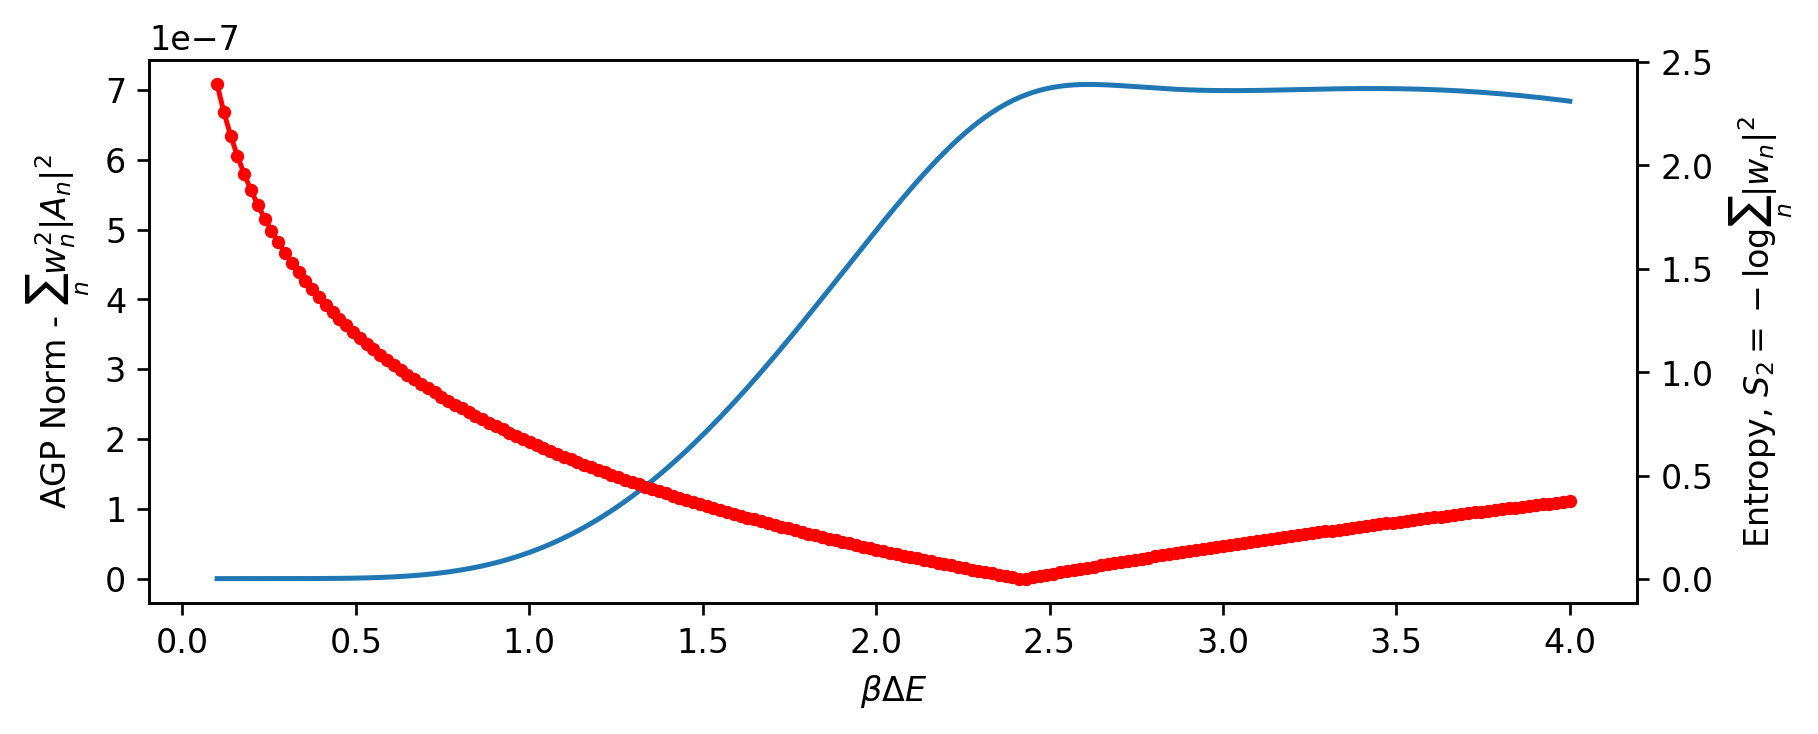

In [22]:
f, (ax) = plt.subplots(1, 1, figsize = (8,3), dpi=240, frameon=False)

# ax.plot(beta_Range*levelSpace, A_n_weight, '-', label="unnorm")  
ax.plot(beta_Range*levelSpace, A_n_weight/norm_2, '-', label="norm") 
ax.set_xlabel(r"$\beta \Delta E$")
ax.set_ylabel(r"AGP Norm - $\sum_n w_n^2 |A_n|^2$")
# ax.legend()
# ax.set_title(r"$a="+str(float(a_q))+"$")
# ax.set_ylim(0,10)

ax2 = ax.twinx()
ax2.plot(beta_Range*levelSpace, np.abs(entropy), 'r.-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_AGPnorm_weighted_new.png"
# f.savefig(filename, dpi=200, bbox_inches='tight') 
print(filename)


## Gibbs distribution Comparison 

1.0548429228260676


Text(0.5, 0, '$x$')

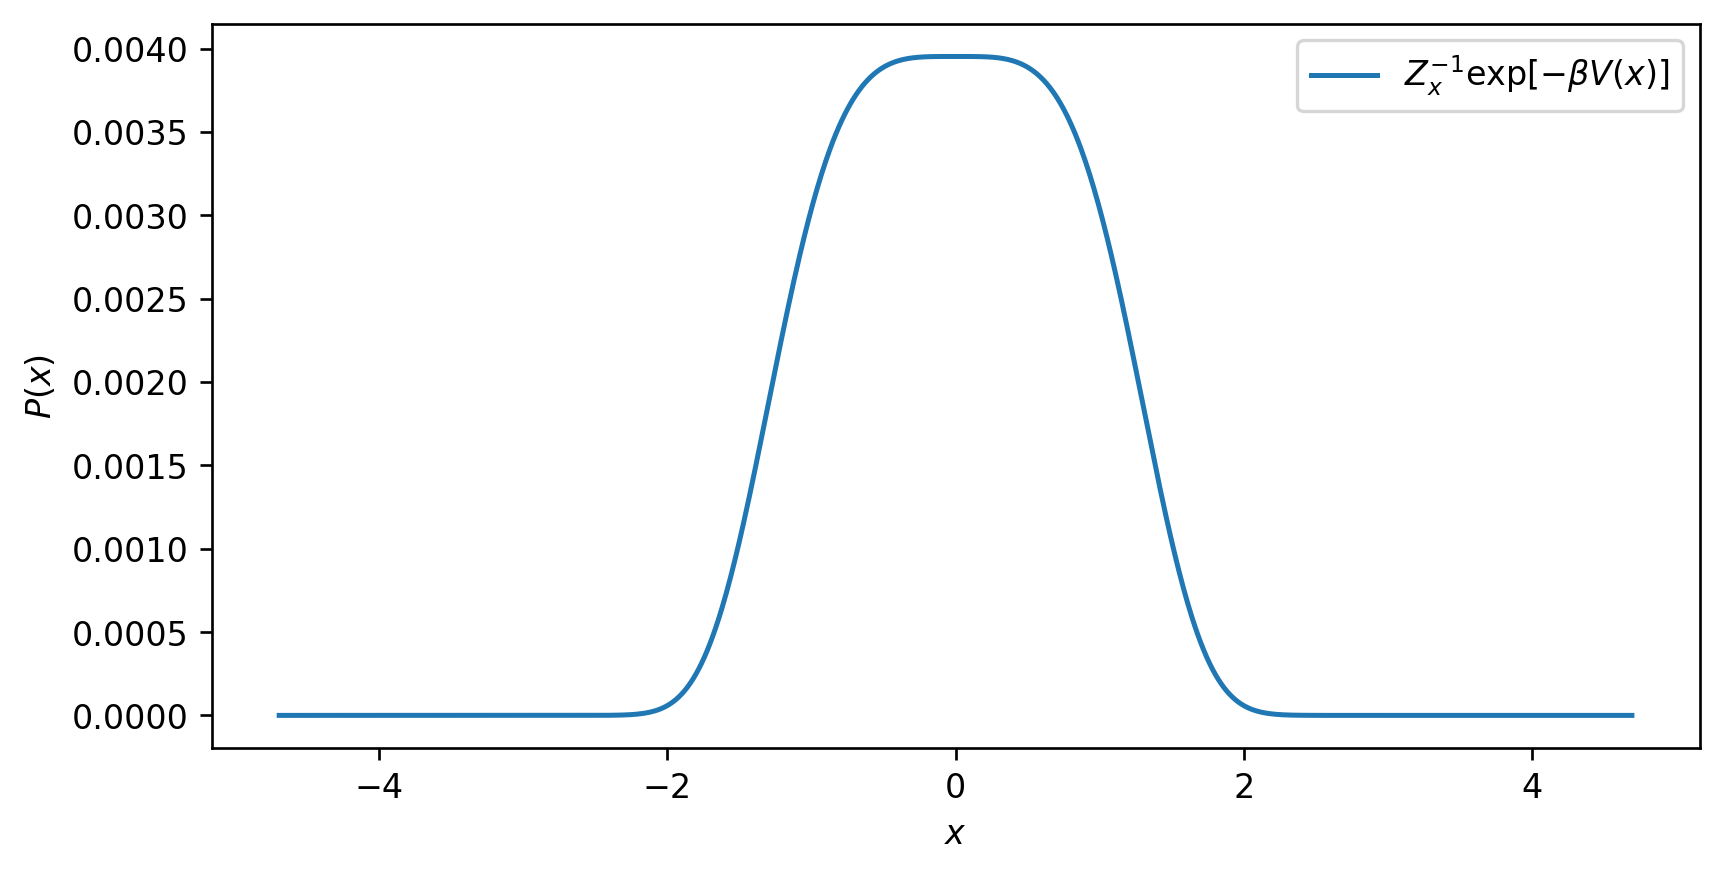

In [54]:
def class_Distr(x, beta): 
    P = np.exp(-beta * (V(x)))
    return P

## Get weights/states
# beta_test = beta_Range[240] #quartic - near maximally discrete point
beta_test = beta_Range[20] #quartic - far from maximally discrete point

# beta_test = beta_Range[100] #asym - near maximally discrete point
# beta_test = beta_Range[45] #asym - far from maximally discrete point



print(beta_test)
x_range_q, w_alph, psi_alph = readInWF(filename_base, filename_base_s, beta_test)


P_gibbs = class_Distr(x_range_q, beta_test)
P_gibbs /= np.sum(P_gibbs)

##Set up figure and important axis
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
ax1.plot(x_range_q, P_gibbs, label=r"$Z_x^{-1}\exp[-\beta V(x)]$")
ax1.legend(fontsize=10)

ax1.set_ylabel(r"$P(x)$")
ax1.set_xlabel(r"$x$")

1.0548429228260676
Plots_W/CM_eps0.3_quart_distr_nMax1_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax2_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax3_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax4_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax5_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax6_beta1.054843.png
Plots_W/CM_eps0.3_quart_distr_nMax7_beta1.054843.png


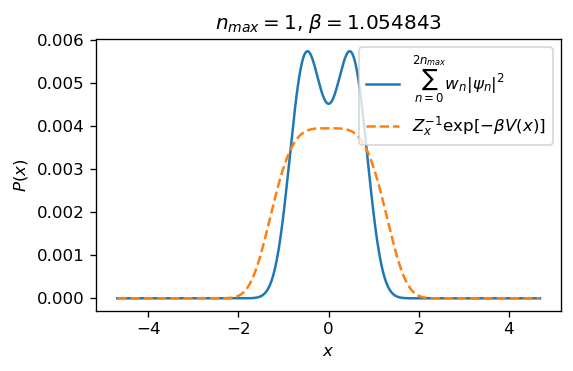

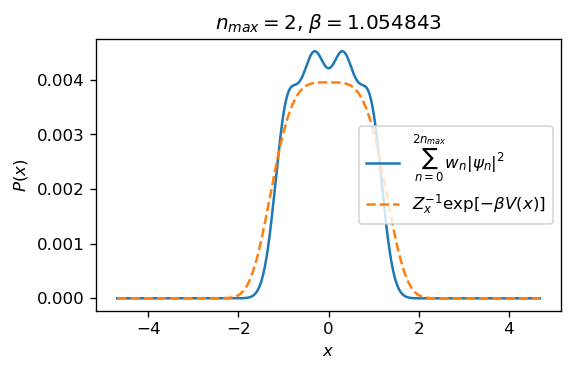

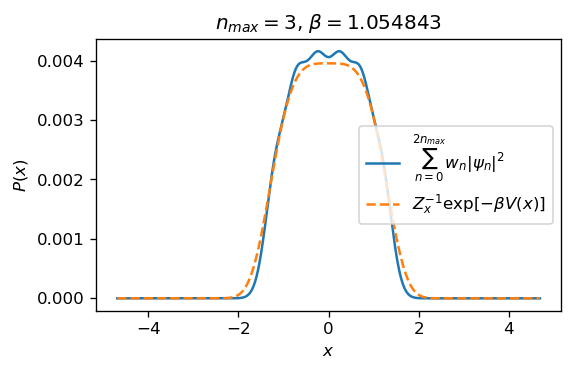

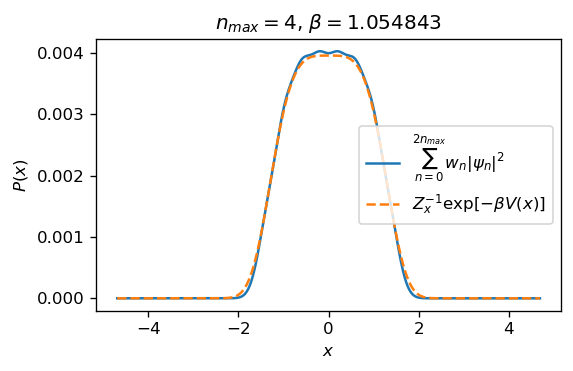

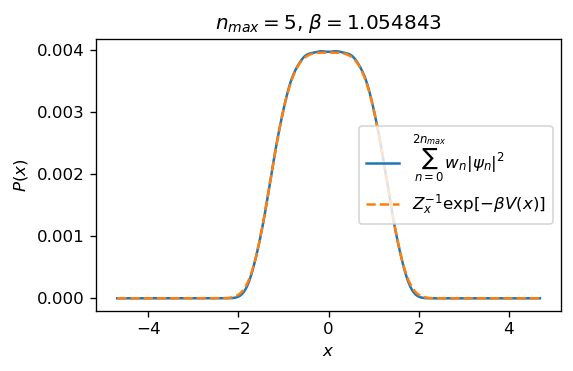

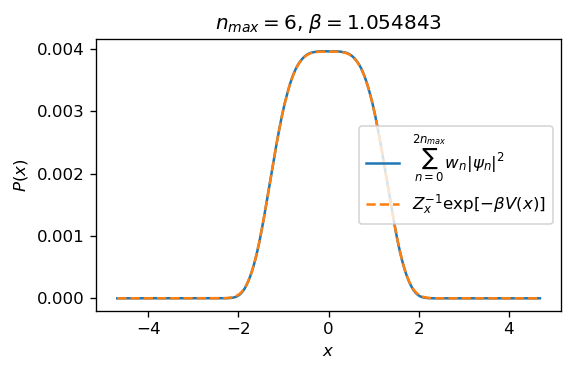

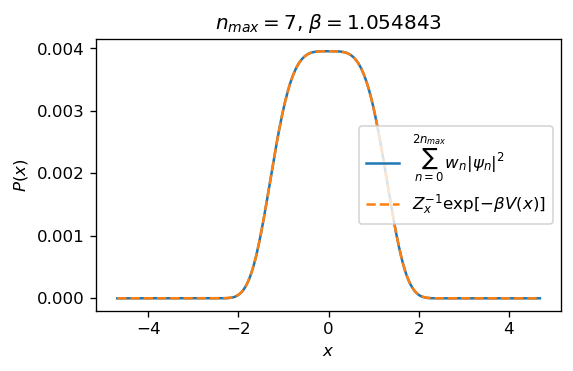

In [55]:
## Compare to sum of first 2n states

print(beta_test)

for n_max in range(1,8): 
    P_gibbs_re = np.zeros(len(x_range_q))

    for n in range(n_max): 
        P_gibbs_re += np.real(w_alph[2*n] * np.abs(psi_alph[:,2*n])**2)
        P_gibbs_re += np.real(w_alph[2*n+1] * np.abs(psi_alph[:,2*n+1])**2)
    P_gibbs_re /= np.sum(P_gibbs_re)

    ##Set up figure and important axis
    f, ax1 = plt.subplots(1, 1, figsize = (5,3), dpi=120, frameon=False)
    ax1.plot(x_range_q, P_gibbs_re, label=r"$\sum_{n=0}^{2n_{max}} w_n |\psi_n|^2$")
    ax1.plot(x_range_q, P_gibbs, '--', label=r"$Z_x^{-1}\exp[-\beta V(x)]$")
    ax1.legend(fontsize=10)
    ax1.set_title(r"$n_{max} = $"+str(n_max)+r", $\beta = $"+str(round(beta_test,6)))
    ax1.set_ylabel(r"$P(x)$")
    ax1.set_xlabel(r"$x$")
    filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_distr_nMax"+str(n_max)+"_beta"+str(round(beta_test,6))+".png"
#     f.savefig(filename, dpi=200, bbox_inches='tight') 
    print(filename)

## Comparing $W$ to few-state approx.

Define a "distance": $Tr (W-W_1)^2$, which is nothing but _the sum of the excluded weights_, $\sum_{i=n_max}^N |w_i|^2$. How does that distance change as we increase $n_{max}$? 

Plots_W/CM_eps0.3_quart_GibbsCompare.png


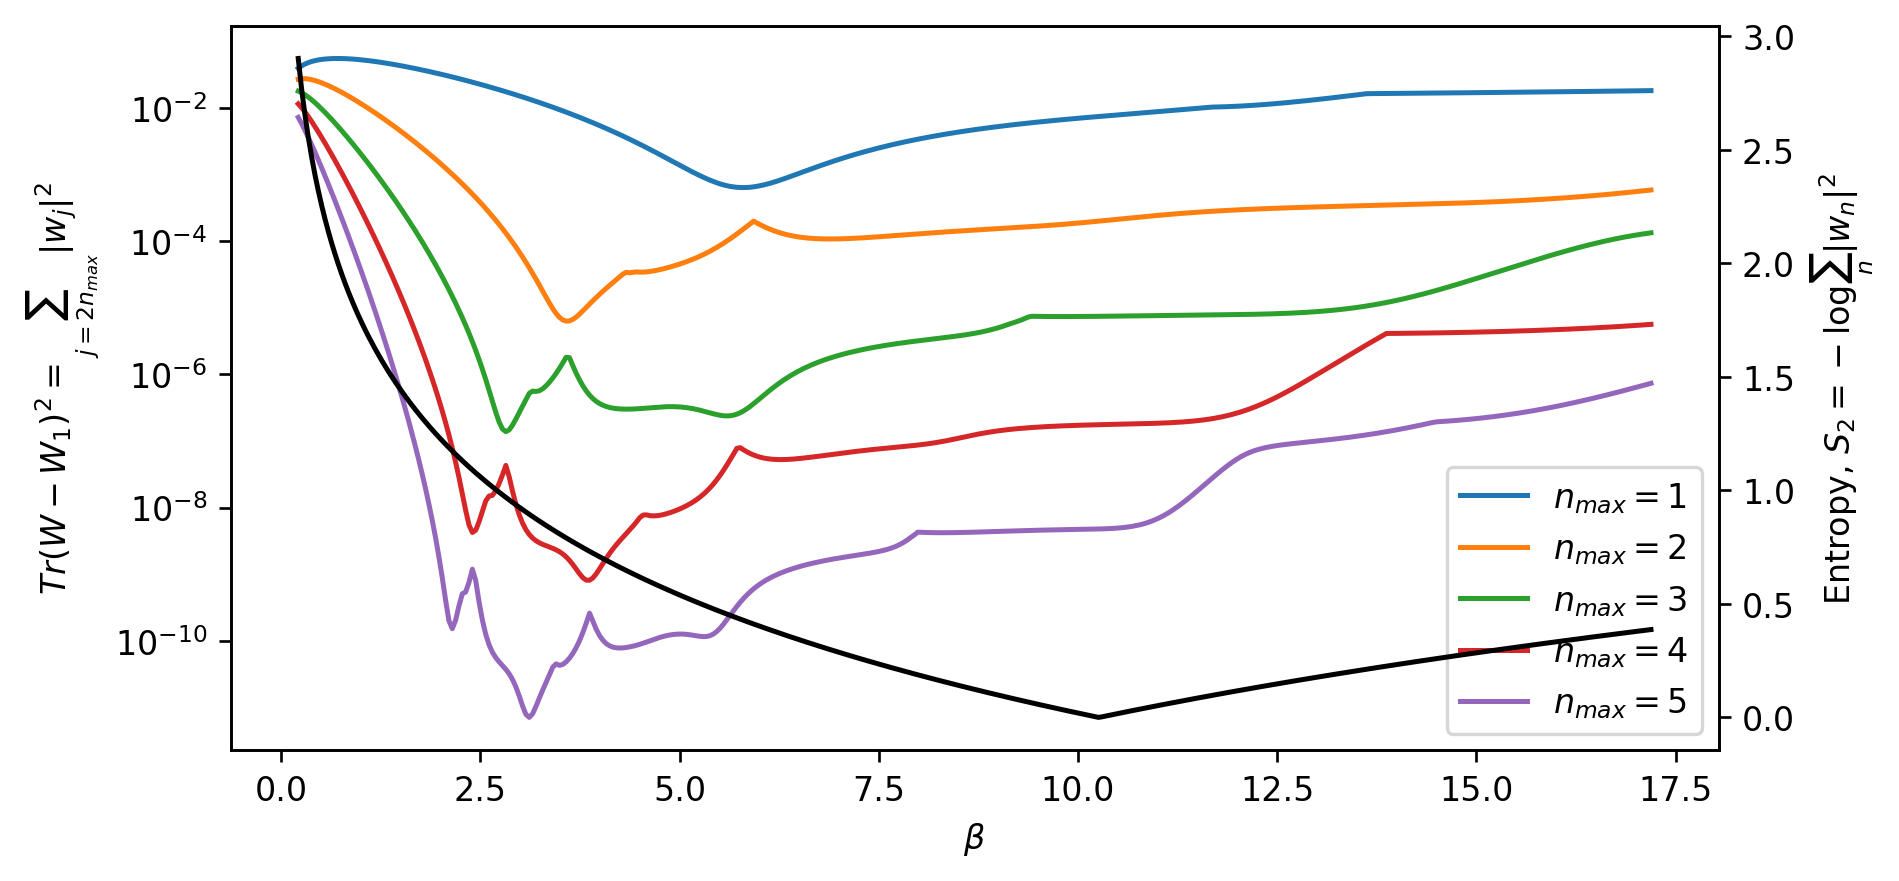

In [46]:
n_max_Range = np.arange(1, 6)

distances = np.zeros((len(n_max_Range),len(beta_Range)))
entropy = np.zeros_like(beta_Range, complex)

for n_max_i, n_max in enumerate(n_max_Range): 
    for j_i, j in enumerate(beta_Range): 
        w_alph = w_alph_list[j_i]
        distances[n_max_i, j_i] = np.sum(np.abs(w_alph[2*n_max:])**2)

for j_i, j in enumerate(beta_Range):   
    w_alph = w_alph_list[j_i]
    entropy[j_i] = -1*np.log(np.abs(np.sum( np.power(w_alph, 2) )))
    
f, ax1 = plt.subplots(1, 1, figsize = (8,4), dpi=240, frameon=False)
for n_max_i, n_max in enumerate(n_max_Range): 
    ax1.plot(beta_Range, distances[n_max_i,:], label=r"$n_{max} = "+str(n_max_Range[n_max_i])+"$")
ax1.legend(fontsize=10)
ax1.set_ylabel(r"$Tr (W-W_1)^2 = \sum_{j=2n_{max}} |w_j|^2$")
ax1.set_xlabel(r"$\beta$")
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.plot(beta_Range, np.abs(entropy), 'k-')
ax2.set_ylabel(r"Entropy, $S_2 = -\log \sum_n |w_n|^2$")
filename = "Plots_W/CM_eps"+str(eps)+"_"+file_save_base+"_GibbsCompare.png"
# f.savefig(filename, dpi=200, bbox_inches='tight')
print(filename)
